## Compare Logistic Regression in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_logistic_regression,
)

In [2]:
metric = "accuracy"

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
orig_df["r"] = interest_rate

### In sample predictions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_logistic_regression(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 00:34:47,942] A new study created in memory with name: no-name-4a3e637d-c121-4a91-837a-a2a503b69e53
[I 2024-02-13 00:34:48,053] Trial 0 finished with value: 0.5514539793654992 and parameters: {'solver': 'newton-cg', 'C': 9.341137201142942, 'tol': 0.0008878151849828306, 'max_iter': 2000}. Best is trial 0 with value: 0.5514539793654992.
[I 2024-02-13 00:34:48,108] Trial 1 finished with value: 0.5442781994668403 and parameters: {'solver': 'sag', 'C': 0.004910708286997467, 'tol': 0.000390605507149005, 'max_iter': 2000}. Best is trial 0 with value: 0.5514539793654992.
[I 2024-02-13 00:34:48,164] Trial 2 finished with value: 0.5466565596955699 and parameters: {'solver': 'newton-cholesky', 'C': 0.35785408048612677, 'tol': 0.0003971184430154148, 'max_iter': 2000}. Best is trial 0 with value: 0.5514539793654992.
[I 2024-02-13 00:34:48,241] Trial 3 finished with value: 0.5554450458883621 and parameters: {'solver': 'liblinear', 'C': 16.184952940677327, 'tol': 7.416519659079734e-05, 

Number of finished trials: 150
Best trial:
  Value: 0.5610259253983435
  Params: 
    solver: liblinear
    C: 43.31380419865235
    tol: 4.307550963466319e-05
    max_iter: 2000


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**study.best_params, random_state=1968)),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=43.31380419865235, max_iter=2000,
                                    random_state=1968, solver='liblinear',
                                    tol=4.307550963466319e-05))])

In [14]:
predictions = pipe.predict(X_test)

In [15]:
pipe.score(X_test, y_test)

0.592964824120603

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       100
           1       0.59      0.58      0.58        99

    accuracy                           0.59       199
   macro avg       0.59      0.59      0.59       199
weighted avg       0.59      0.59      0.59       199



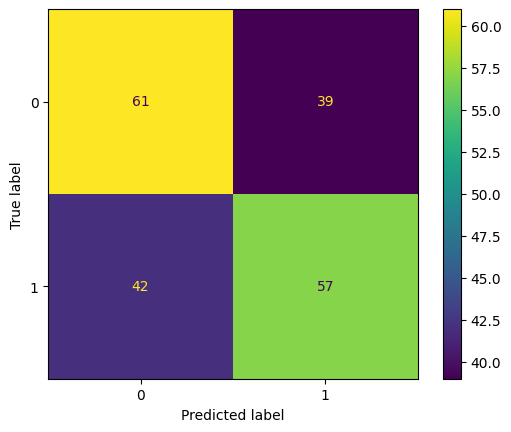

In [16]:
display_report(y_test, predictions)

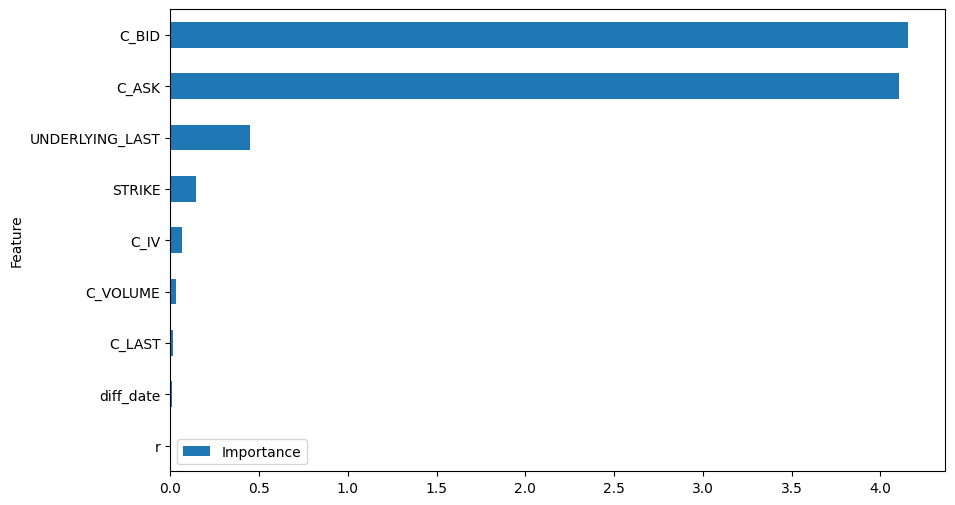

In [17]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [18]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [19]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [20]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,1,280.0,2.40,2018-02-07,267.670013,-2.400000,-2.400000,-2.400000,-2.400000
2018-02-09,1,262.0,5.77,2018-03-02,269.079987,1.309987,1.309987,-1.090013,-1.090013
2018-02-22,1,270.0,4.26,2018-03-14,275.299988,1.039988,1.039988,-0.050026,-0.050026
2018-02-28,1,271.0,4.86,2018-03-21,270.429993,-4.860000,-4.860000,-4.910026,-4.910026
2018-03-08,1,274.0,2.85,2018-03-29,263.149994,-2.850000,-2.850000,-7.760026,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,0,455.0,5.55,2023-12-15,469.329987,0.000000,8.779987,340.600052,286.530096
2023-11-27,0,455.0,4.55,2023-12-15,469.329987,0.000000,9.779987,340.600052,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,340.600052,308.580077


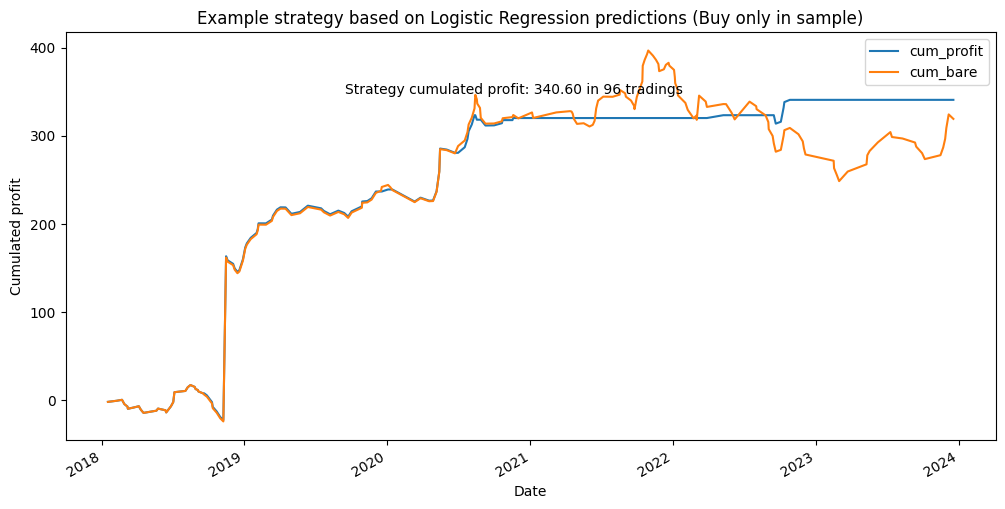

In [21]:
plot_strategy(strategy_df, "Logistic Regression", "(Buy only in sample)")

### Out-of-sample predictions

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [23]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**study.best_params, random_state=1968)),
    ]
)

In [24]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=43.31380419865235, max_iter=2000,
                                    random_state=1968, solver='liblinear',
                                    tol=4.307550963466319e-05))])

In [25]:
predictions = pipe.predict(X_test)

In [26]:
pipe.score(X_test, y_test)

0.49246231155778897

/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        98
           1       0.00      0.00      0.00       101

    accuracy                           0.49       199
   macro avg       0.25      0.50      0.33       199
weighted avg       0.24      0.49      0.32       199



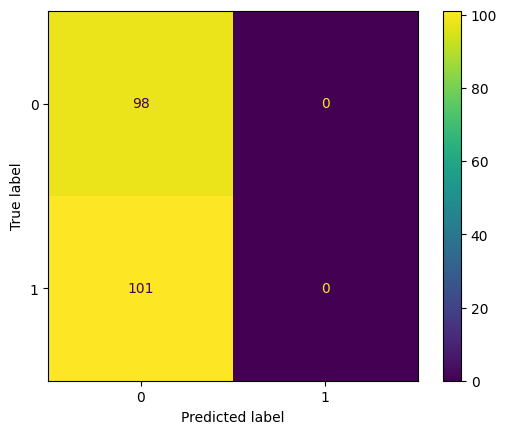

In [27]:
display_report(y_test, predictions)

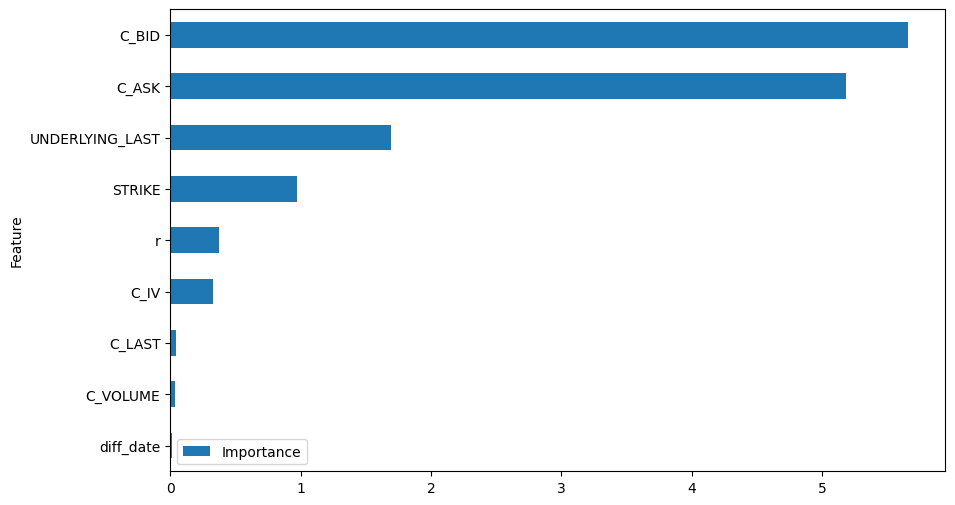

In [28]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [29]:
compare_df["bare_rf_pred_out"] = predictions

### Backtesting

In [30]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [31]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,0,384.0,7.46,2023-01-27,405.679993,0.0,14.219993,0.0,14.219993
2023-01-05,0,379.0,8.50,2023-01-27,405.679993,0.0,18.179993,0.0,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.0,9.959993,0.0,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.0,10.219993,0.0,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.0,8.240006,0.0,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,0.0,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,0.0,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,0.0,401.389886


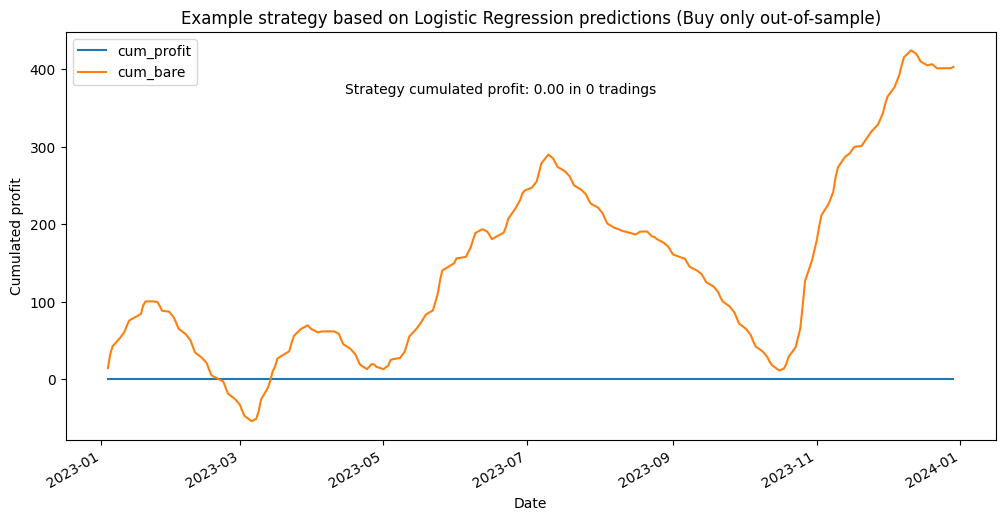

In [32]:
plot_strategy(strategy_df, "Logistic Regression", "(Buy only out-of-sample)")

## Logistic Regression with data from MC simulation and additional features

In [33]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [34]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_logistic_regression(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 00:35:12,472] A new study created in memory with name: no-name-13cf10a4-141f-4ac2-a7cc-b3d757a32f32
[I 2024-02-13 00:35:13,164] Trial 0 finished with value: 0.5458603813516208 and parameters: {'solver': 'saga', 'C': 0.12852663381811694, 'tol': 0.00024883955616518167, 'max_iter': 2000, 'penalty': 'l1'}. Best is trial 0 with value: 0.5458603813516208.
[I 2024-02-13 00:35:13,624] Trial 1 finished with value: 0.5506781506277854 and parameters: {'solver': 'sag', 'C': 19.88118498917952, 'tol': 0.0009214565404922751, 'max_iter': 2000}. Best is trial 1 with value: 0.5506781506277854.
[I 2024-02-13 00:35:13,721] Trial 2 finished with value: 0.5450540282045542 and parameters: {'solver': 'liblinear', 'C': 0.013626223045459402, 'tol': 0.000897680704022935, 'max_iter': 2000}. Best is trial 1 with value: 0.5506781506277854.
[I 2024-02-13 00:35:13,937] Trial 3 finished with value: 0.5466870841049225 and parameters: {'solver': 'newton-cg', 'C': 53.12847175055946, 'tol': 0.000728840021589

Number of finished trials: 150
Best trial:
  Value: 0.5682042489977819
  Params: 
    solver: newton-cholesky
    C: 0.24331292746112423
    tol: 0.0006905919712740121
    max_iter: 2000


In [37]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**study.best_params, random_state=1968)),
    ]
)

In [38]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=0.24331292746112423, max_iter=2000,
                                    random_state=1968, solver='newton-cholesky',
                                    tol=0.0006905919712740121))])

In [39]:
predictions = pipe.predict(X_test)

In [40]:
pipe.score(X_test, y_test)

0.5979899497487438

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       100
           1       0.65      0.41      0.51        99

    accuracy                           0.60       199
   macro avg       0.61      0.60      0.58       199
weighted avg       0.61      0.60      0.58       199



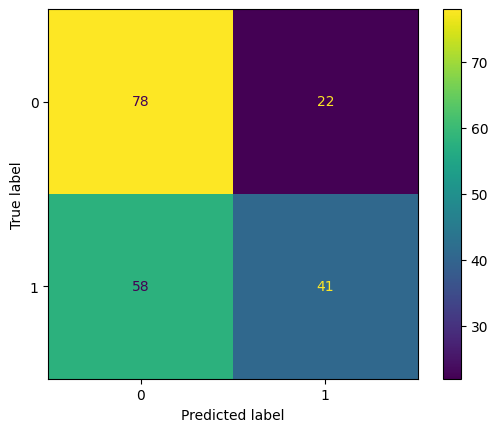

In [41]:
display_report(y_test, predictions)

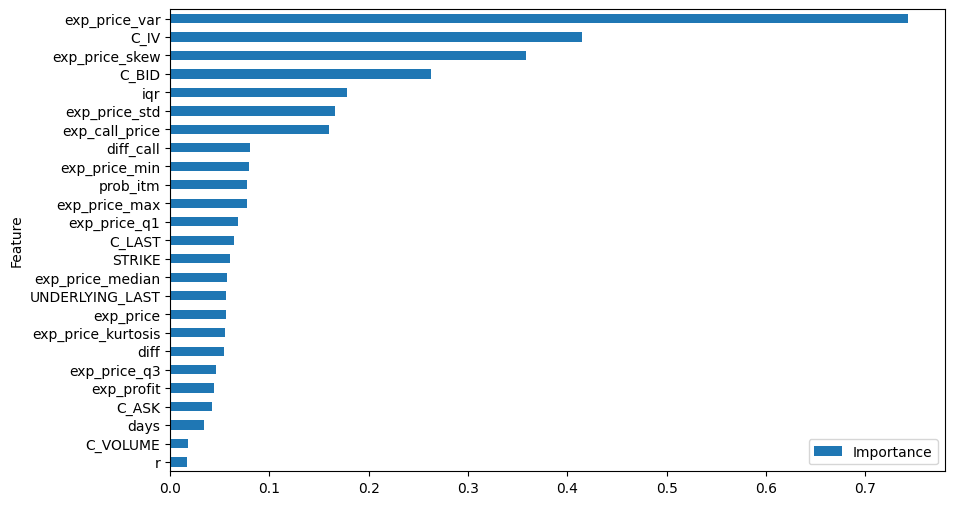

In [42]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [43]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [44]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [45]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,1,280.0,2.40,2018-02-07,267.670013,-2.400000,-2.400000,-2.400000,-2.400000
2018-02-09,1,262.0,5.77,2018-03-02,269.079987,1.309987,1.309987,-1.090013,-1.090013
2018-02-22,1,270.0,4.26,2018-03-14,275.299988,1.039988,1.039988,-0.050026,-0.050026
2018-02-28,1,271.0,4.86,2018-03-21,270.429993,-4.860000,-4.860000,-4.910026,-4.910026
2018-03-08,1,274.0,2.85,2018-03-29,263.149994,-2.850000,-2.850000,-7.760026,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,0,455.0,5.55,2023-12-15,469.329987,0.000000,8.779987,332.590001,286.530096
2023-11-27,0,455.0,4.55,2023-12-15,469.329987,0.000000,9.779987,332.590001,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,332.590001,308.580077


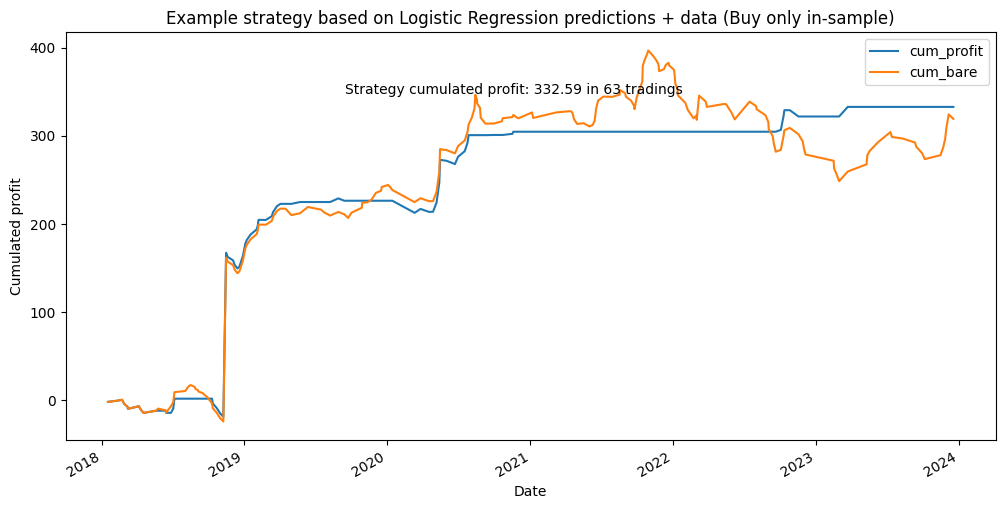

In [46]:
plot_strategy(strategy_df, "Logistic Regression", "+ data (Buy only in-sample)")

### Out-of-sample predictions

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [48]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", LogisticRegression(**study.best_params, random_state=1968)),
    ]
)

In [49]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 LogisticRegression(C=0.24331292746112423, max_iter=2000,
                                    random_state=1968, solver='newton-cholesky',
                                    tol=0.0006905919712740121))])

In [50]:
predictions = pipe.predict(X_test)

In [51]:
pipe.score(X_test, y_test)

0.49246231155778897

/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

              precision    recall  f1-score   support

           0       0.49      1.00      0.66        98
           1       0.00      0.00      0.00       101

    accuracy                           0.49       199
   macro avg       0.25      0.50      0.33       199
weighted avg       0.24      0.49      0.32       199



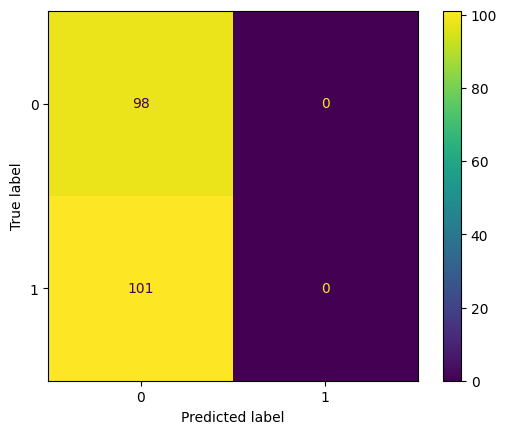

In [52]:
display_report(y_test, predictions)

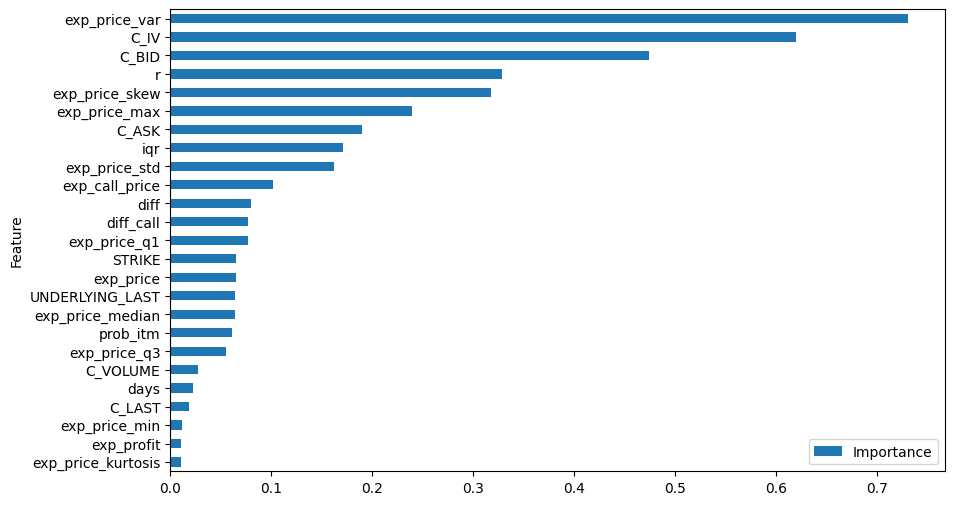

In [53]:
coefficients = pipe.named_steps["rf"].coef_[0]
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [54]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [55]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [56]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,0,384.0,7.46,2023-01-27,405.679993,0.0,14.219993,0.0,14.219993
2023-01-05,0,379.0,8.50,2023-01-27,405.679993,0.0,18.179993,0.0,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.0,9.959993,0.0,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.0,10.219993,0.0,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.0,8.240006,0.0,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,0.0,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,0.0,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,0.0,401.389886


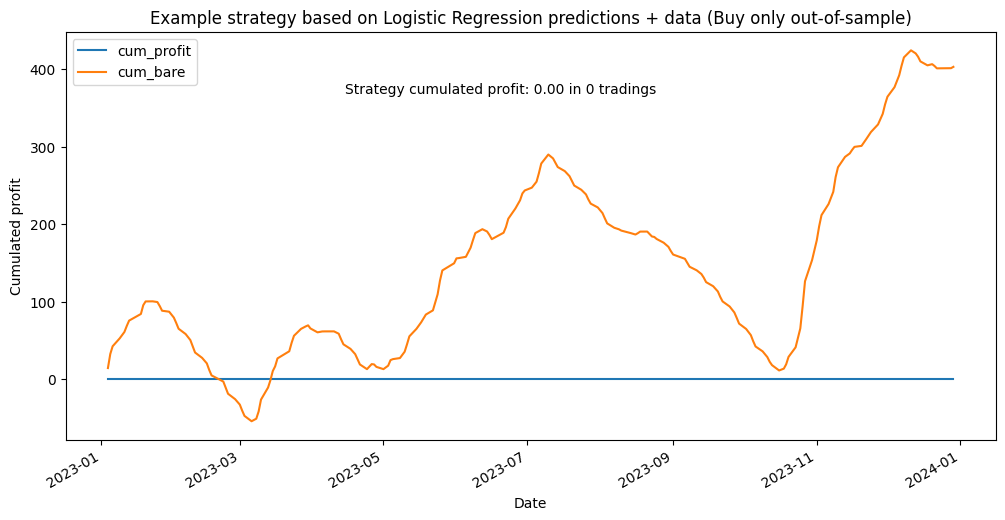

In [57]:
plot_strategy(strategy_df, "Logistic Regression", "+ data (Buy only out-of-sample)")

## Compare the two predictions

In [58]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [59]:
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
7,0,0,1,0
9,1,0,0,0
12,1,0,0,0
15,1,0,0,0
16,1,0,0,0
25,1,0,0,0
28,1,0,0,0
33,1,0,0,0
40,0,0,1,0
45,1,0,0,0


In [60]:
compare_df[mask_in].shape

(41, 4)

In [61]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out


In [62]:
compare_df[mask_out].shape

(0, 4)

In [63]:
compare_df.sum(axis=0)

bare_rf_pred_in     96
bare_rf_pred_out     0
mmar_rf_pred_in     63
mmar_rf_pred_out     0
dtype: int64